# **<span style="color: #87CEEB;"> CS437/CS5317/EE414/EE513 Deep Learning Programming Assignment 1</span>**

# <span style="color: #9370DB;">**Submission Guidelines**</span>

- <span style="color: #9370DB;">Please rename the file to `<RollNumber>_PA1_2_3`.</span>
- <span style="color: #9370DB;">Please also submit a **.py** file of every Notebook. You can do this by exporting your **ipynb** to a Python script.</span>
- <span style="color: #9370DB;">Please submit a zipped folder of both your Jupyter Notebooks and Python script files.</span>




### Name: Zaeem Yousaf
### Roll Number: 23030021

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

import glob
import cv2
import os

from torchsummary import summary
from tqdm.notebook import tqdm


<h1><b> Part 2 Task 3 : Sparse CNN Layers<span style="color: #9370DB;"> (50 Points Total)</span></b></h1> 

In this section, you will classify CIFAR-10 ising sparse CNN. You will replace the standard CNN layers with sparse CNN layers. Sparse CNN layers are useful for reducing the number of parameters in the model, which can lead to faster inference times and lower memory usage. It would be helpful to have a look of this article to explor more about sparse CNN: https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Liu_Sparse_Convolutional_Neural_2015_CVPR_paper.pdf

You are required to implement a sparse CNN layer by applying pruning to the weights of the convolutional layers. PyTorch provides utilities for pruning in the `torch.nn.utils.prune` module.

## Task:
1. Implement a sparse CNN layer by applying pruning to the weights of the convolutional layers.
3. Train the model with the sparse CNN layers and compare its performance with the original model.

Here you need to implement Sparse CNN Layer using PyTorch's pruning utilities.

In [2]:
import torch.nn as nn
import torch.nn.utils.prune as prune

class SparseConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, pruning_amount=0.5):
        super(SparseConv2d, self).__init__()
        # Initialize the Conv2d layer
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding)
        
        # Apply pruning on the conv layer's weights
        prune.l1_unstructured(self.conv, name='weight', amount=pruning_amount)
        
    def forward(self, x):
        return self.conv(x)


In [3]:
class SparseModel(nn.Module):
    def __init__(self):
        super(SparseModel, self).__init__()
        self.layer1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.layer2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

        # Use dummy input to calculate flattened feature size
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 64, 64)
            dummy_output = self.pool(self.relu(self.layer2(self.pool(self.relu(self.layer1(dummy_input))))))
            self.flattened_size = dummy_output.view(1, -1).size(1)

        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.fc2 = nn.Linear(256, 10)  # Adjust output size to your number of classes

    def forward(self, x):
        x = self.pool(self.relu(self.layer1(x)))
        x = self.pool(self.relu(self.layer2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


Download CIFAR-10, use the SparseConv2d layer instead of the standard nn.Conv2d layer.

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms

# Define transformations for CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

# Load CIFAR-10 training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

# Load CIFAR-10 test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)


100%|██████████| 170M/170M [00:03<00:00, 49.1MB/s] 


# Train your Sparse CNN
In this section, you are required to train your Sparse CNN on the Pokemon Dataset. You may change the `criterion`, `optimizer`, `lr` and `NUM_EPOCHS`.
You have to implement the model training for each epoch.

In [5]:
sparse_model = SparseModel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(sparse_model.parameters(), lr=0.001)  # fixed here
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sparse_model.to(device)

summary(sparse_model, input_size=(3, 64, 64))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
              ReLU-2           [-1, 32, 64, 64]               0
         MaxPool2d-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
              ReLU-5           [-1, 64, 32, 32]               0
         MaxPool2d-6           [-1, 64, 16, 16]               0
            Linear-7                  [-1, 256]       4,194,560
              ReLU-8                  [-1, 256]               0
           Dropout-9                  [-1, 256]               0
           Linear-10                   [-1, 10]           2,570
Total params: 4,216,522
Trainable params: 4,216,522
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 3.38
Params size (MB): 16.08
Estima

In [6]:
# Replace this with the actual Pokemon dataset if available
# Here's an example using CIFAR-10 as a stand-in:
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, transform=transform, download=True
)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define image transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to 64x64
    transforms.ToTensor()
])

# Load CIFAR-10 dataset as a placeholder
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define the Sparse CNN model
class SparseModel(nn.Module):
    def __init__(self):
        super(SparseModel, self).__init__()
        self.layer1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.layer2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

        # Dynamically compute the flattened size after conv layers
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 64, 64)
            dummy_output = self._forward_conv(dummy_input)
            self.flattened_size = dummy_output.view(1, -1).size(1)

        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.fc2 = nn.Linear(256, 10)  # 10 classes for CIFAR-10

    def _forward_conv(self, x):
        x = self.pool(self.relu(self.layer1(x)))
        x = self.pool(self.relu(self.layer2(x)))
        return x

    def forward(self, x):
        x = self._forward_conv(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Initialize model, loss, optimizer
sparse_model = SparseModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(sparse_model.parameters(), lr=0.001)

# Training loop
NUM_EPOCHS = 10
for epoch in range(NUM_EPOCHS):
    sparse_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = sparse_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.2f}%")


Using device: cuda
Epoch [1/10] Loss: 1.6190 Accuracy: 41.57%
Epoch [2/10] Loss: 1.3159 Accuracy: 52.69%
Epoch [3/10] Loss: 1.1800 Accuracy: 57.73%
Epoch [4/10] Loss: 1.0917 Accuracy: 61.02%
Epoch [5/10] Loss: 1.0126 Accuracy: 63.84%
Epoch [6/10] Loss: 0.9458 Accuracy: 66.40%
Epoch [7/10] Loss: 0.8864 Accuracy: 68.33%
Epoch [8/10] Loss: 0.8324 Accuracy: 70.13%
Epoch [9/10] Loss: 0.7789 Accuracy: 71.94%
Epoch [10/10] Loss: 0.7365 Accuracy: 73.39%


# Evaluate your Sparse CNN
In this section, you will set your Sparse model in evaluation mode and evaluate it on your test data. 
You have to implement the evaluation loop and report the test accuracy.

In [8]:
# Define test dataset and DataLoader (if not already defined)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [9]:
# Evaluate the sparse model
sparse_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = sparse_model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy of Sparse Model: {100 * correct / total:.2f}%")


Test Accuracy of Sparse Model: 67.65%


Evaluate Spare model performance and mofidy the code where it necessary

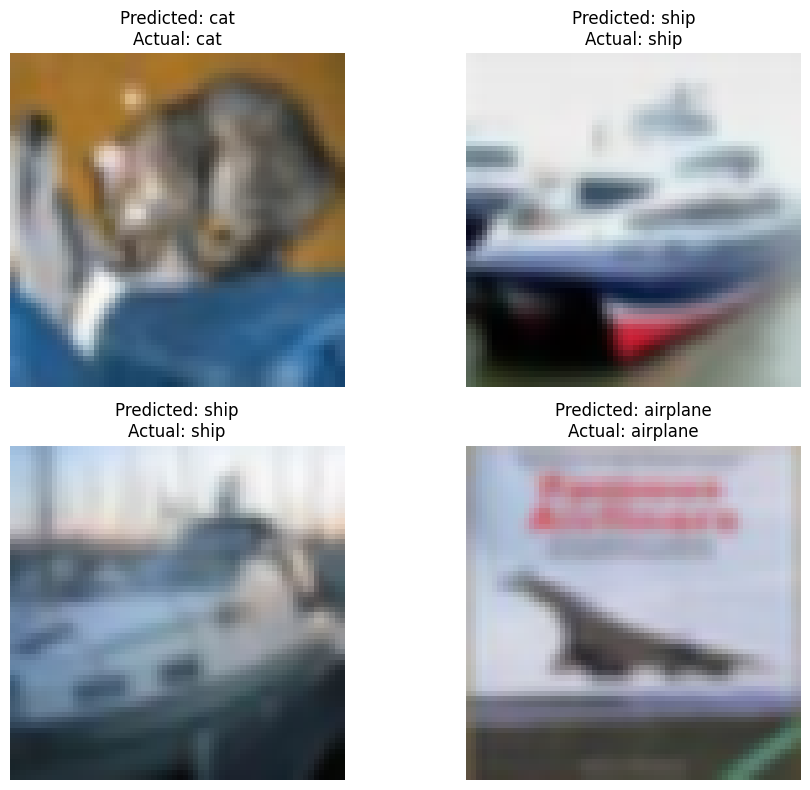

In [11]:
# Set model to evaluation mode
sparse_model.eval()

# Plot 4 test images with predictions
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Iterate through 4 individual test samples
for i in range(4):
    image, label = test_dataset[i]
    input_tensor = image.unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        output = sparse_model(input_tensor)
        _, predicted = torch.max(output, 1)

    # Convert image to numpy for display
    img = image.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)

    ax = axes[i // 2, i % 2]
    ax.imshow(img)
    ax.set_title(f"Predicted: {classes[predicted.item()]}\nActual: {classes[label]}")
    ax.axis("off")

plt.tight_layout()
plt.show()


# Reflection Questions

1. What is the trade-off between model sparsity and accuracy?
2. How does pruning affect the training time and inference speed?

1. What is the trade-off between model sparsity and accuracy?
When we make the model sparse (like removing some weights or connections), it can run faster and use less memory. But if we remove too much, the model might forget important stuff and get less accurate. So the trade-off is between making it small and fast, but not too much that it gets dumb. We gotta find a balance.

2. How does pruning affect the training time and inference speed?
Pruning makes the model smaller by cutting out useless parts. Because of that, it can train faster and also make predictions faster (that’s inference). But sometimes, if we prune too early or too hard, training gets weird and the model learns slower or bad. So it helps speed, but we have to be careful when and how we do it.

